In [1]:
!pip install dionysus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440669 sha256=658592257c8fa18d47fc23e8fdbbde5384bf2c7de92e6149ff38a9cab6b21118
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus


In [2]:
!pip install POT
!pip install gudhi
!pip install importlib-metadata==4.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [3]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import ot
import dionysus as d
from gudhi.wasserstein import wasserstein_distance as wd
from sklearn.cluster import KMeans

In [4]:
from numpy import linalg as LA

In [5]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float, radius: list):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [radius[kk] * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), radius[kk] * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return circle_point_clouds, sphere_point_clouds #point_clouds#, labels

def make_line_point_cloud(n_samples_per_shape: int, n_points: int, noise: float):
    line_point_clouds = [
            np.asarray(
                [
                    [t/(n_points ** 2), (t/(n_points ** 2) + 2 + noise * (np.random.rand(1)[0] - 0.5))]
                    for t in range((n_points ** 2))
                ]
            )
            for kk in range(n_samples_per_shape)
        ]

    #for kk in range(n_samples_per_shape):
    #    x = np.linspace(0, 2 * np.pi, n_points ** 2)  # 100 data points from 0 to 2*pi
    #    y = np.sin(x)

    return line_point_clouds

In [6]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()

In [7]:
def getPD(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    return [[birth0,death0],[birth1,death1]]

In [8]:
def coordinates_to_image(x_coords, y_coords, image_size=(100, 100)):
    # Create an array of zeros with the specified image size
    image = np.zeros(image_size, dtype=int)

    # Normalize the coordinates to fit within the image size
    x_coords = ((x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))) * (image_size[0] - 1)
    y_coords = ((y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))) * (image_size[1] - 1)

    # Round the coordinates to the nearest integer and set corresponding pixels to 1
    x_coords = np.round(x_coords).astype(int)
    y_coords = np.round(y_coords).astype(int)
    image[y_coords, x_coords] = 1

    return image

In [9]:
n_samples_per_shape = 7
n_points = 5
noise = 0.0
radius = [0.8, 1.0, 1.2, 1.4, 1.2, 1.0, 0.8]



circle_point_clouds, sphere_point_clouds = make_point_clouds(n_samples_per_shape, n_points, noise, radius)
lineSample = make_line_point_cloud(n_samples_per_shape, n_points, noise)

samples = []
for s in circle_point_clouds:
    temp = s[:, 0:2]
    samples.append(temp)

# First 7 samples are circle point clouds. Last 7 samples are line point clouds.
samples = lineSample[0:3] + samples + lineSample[3:]

In [10]:
def getPD(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    return [[birth0,death0],[birth1,death1]]

def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()

In [11]:
pd0_union = []
pd1_union = []
pd0 = []
pd1 = []

PD_dict = {}
for i in np.arange(n_samples_per_shape*2):
    print ('Working on number {}'.format(i))
    p0, p1 = getPD(samples[i], 3)
    #PD_dict['PD{}'.format(i)] = np.vstack((np.column_stack((p0[0],p0[1])), np.column_stack((p1[0],p1[1]))))
    #np.savez('/content/drive/My Drive/Coding2/PD{}'.format(i), PD_dict['PD{}'.format(i)])

    #PD_dict['PD{} dim0'.format(i)] = np.column_stack((p0[0],p0[1]))
    #PD_dict['PD{} dim1'.format(i)] = np.column_stack((p1[0],p1[1]))
    #np.savez('/content/drive/My Drive/Coding2/PD{} dim0'.format(i), PD_dict['PD{} dim0'.format(i)])
    #np.savez('/content/drive/My Drive/Coding2/PD{} dim1'.format(i), PD_dict['PD{} dim1'.format(i)])

    pd0_union.append(p0)
    pd1_union.append(p1)
    pd0.append(p0)
    pd1.append(p1)

Working on number 0
Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
Working on number 8
Working on number 9
Working on number 10
Working on number 11
Working on number 12
Working on number 13


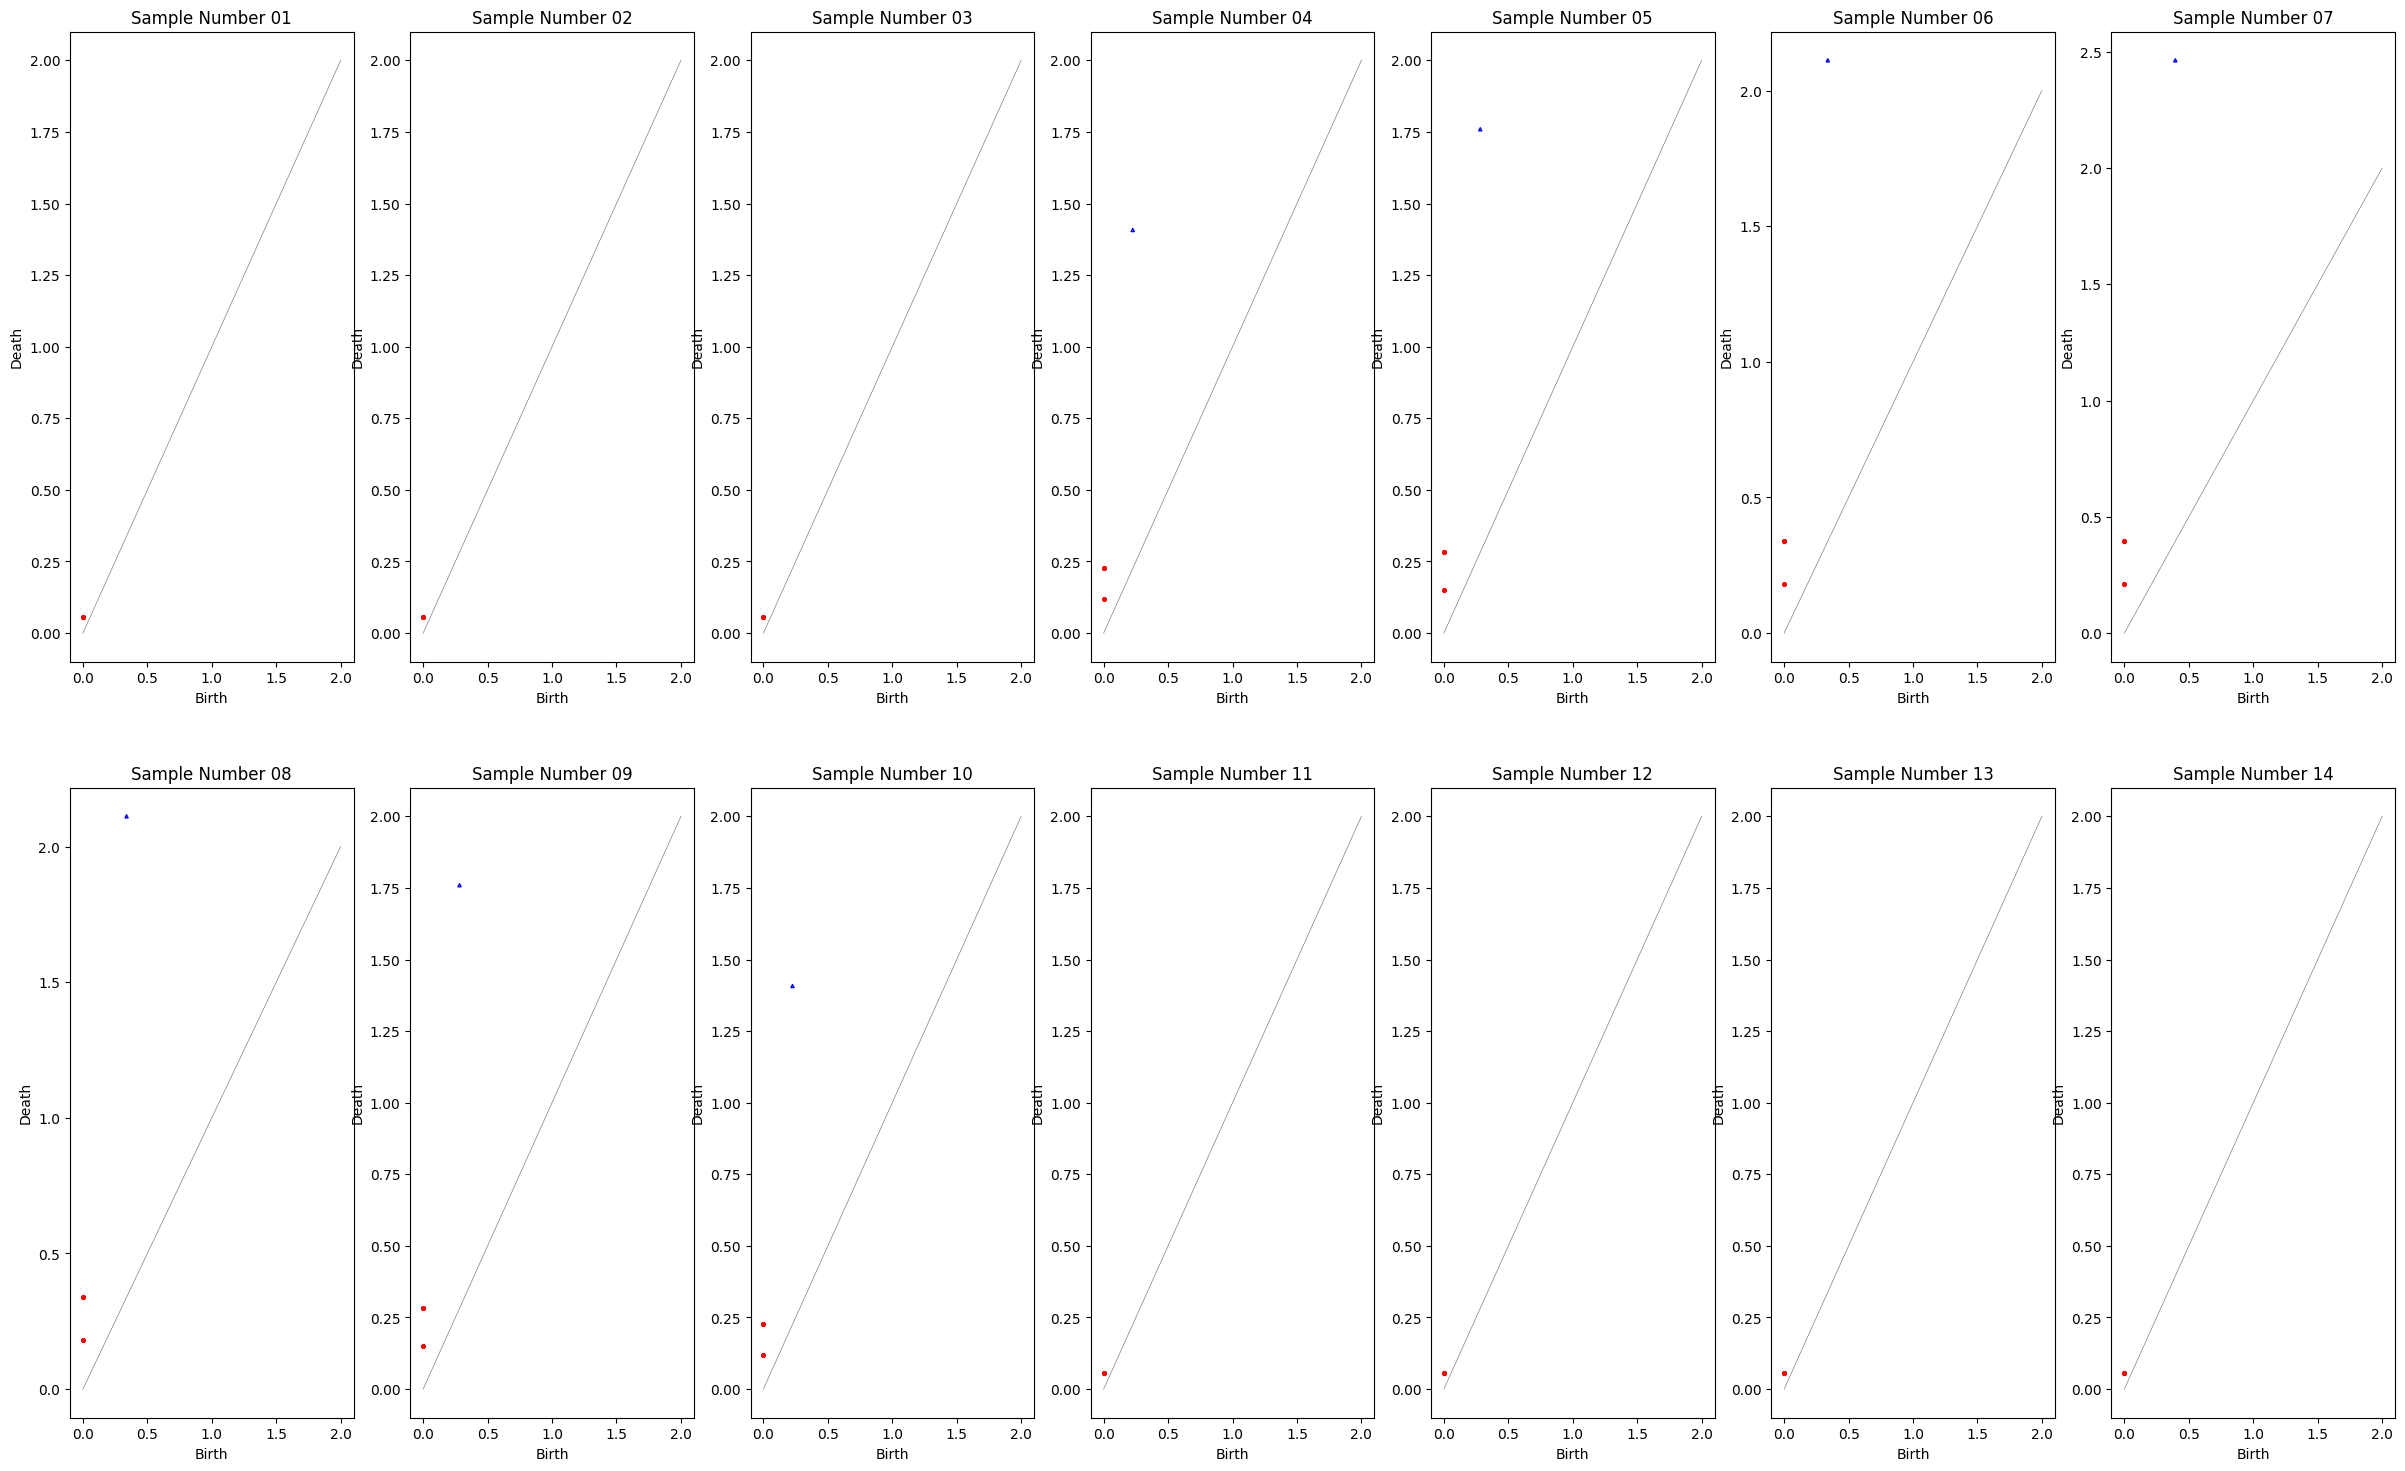

In [12]:
titles = ['Sample Number %02d' %(i+1) for i in np.arange(n_samples_per_shape*2)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

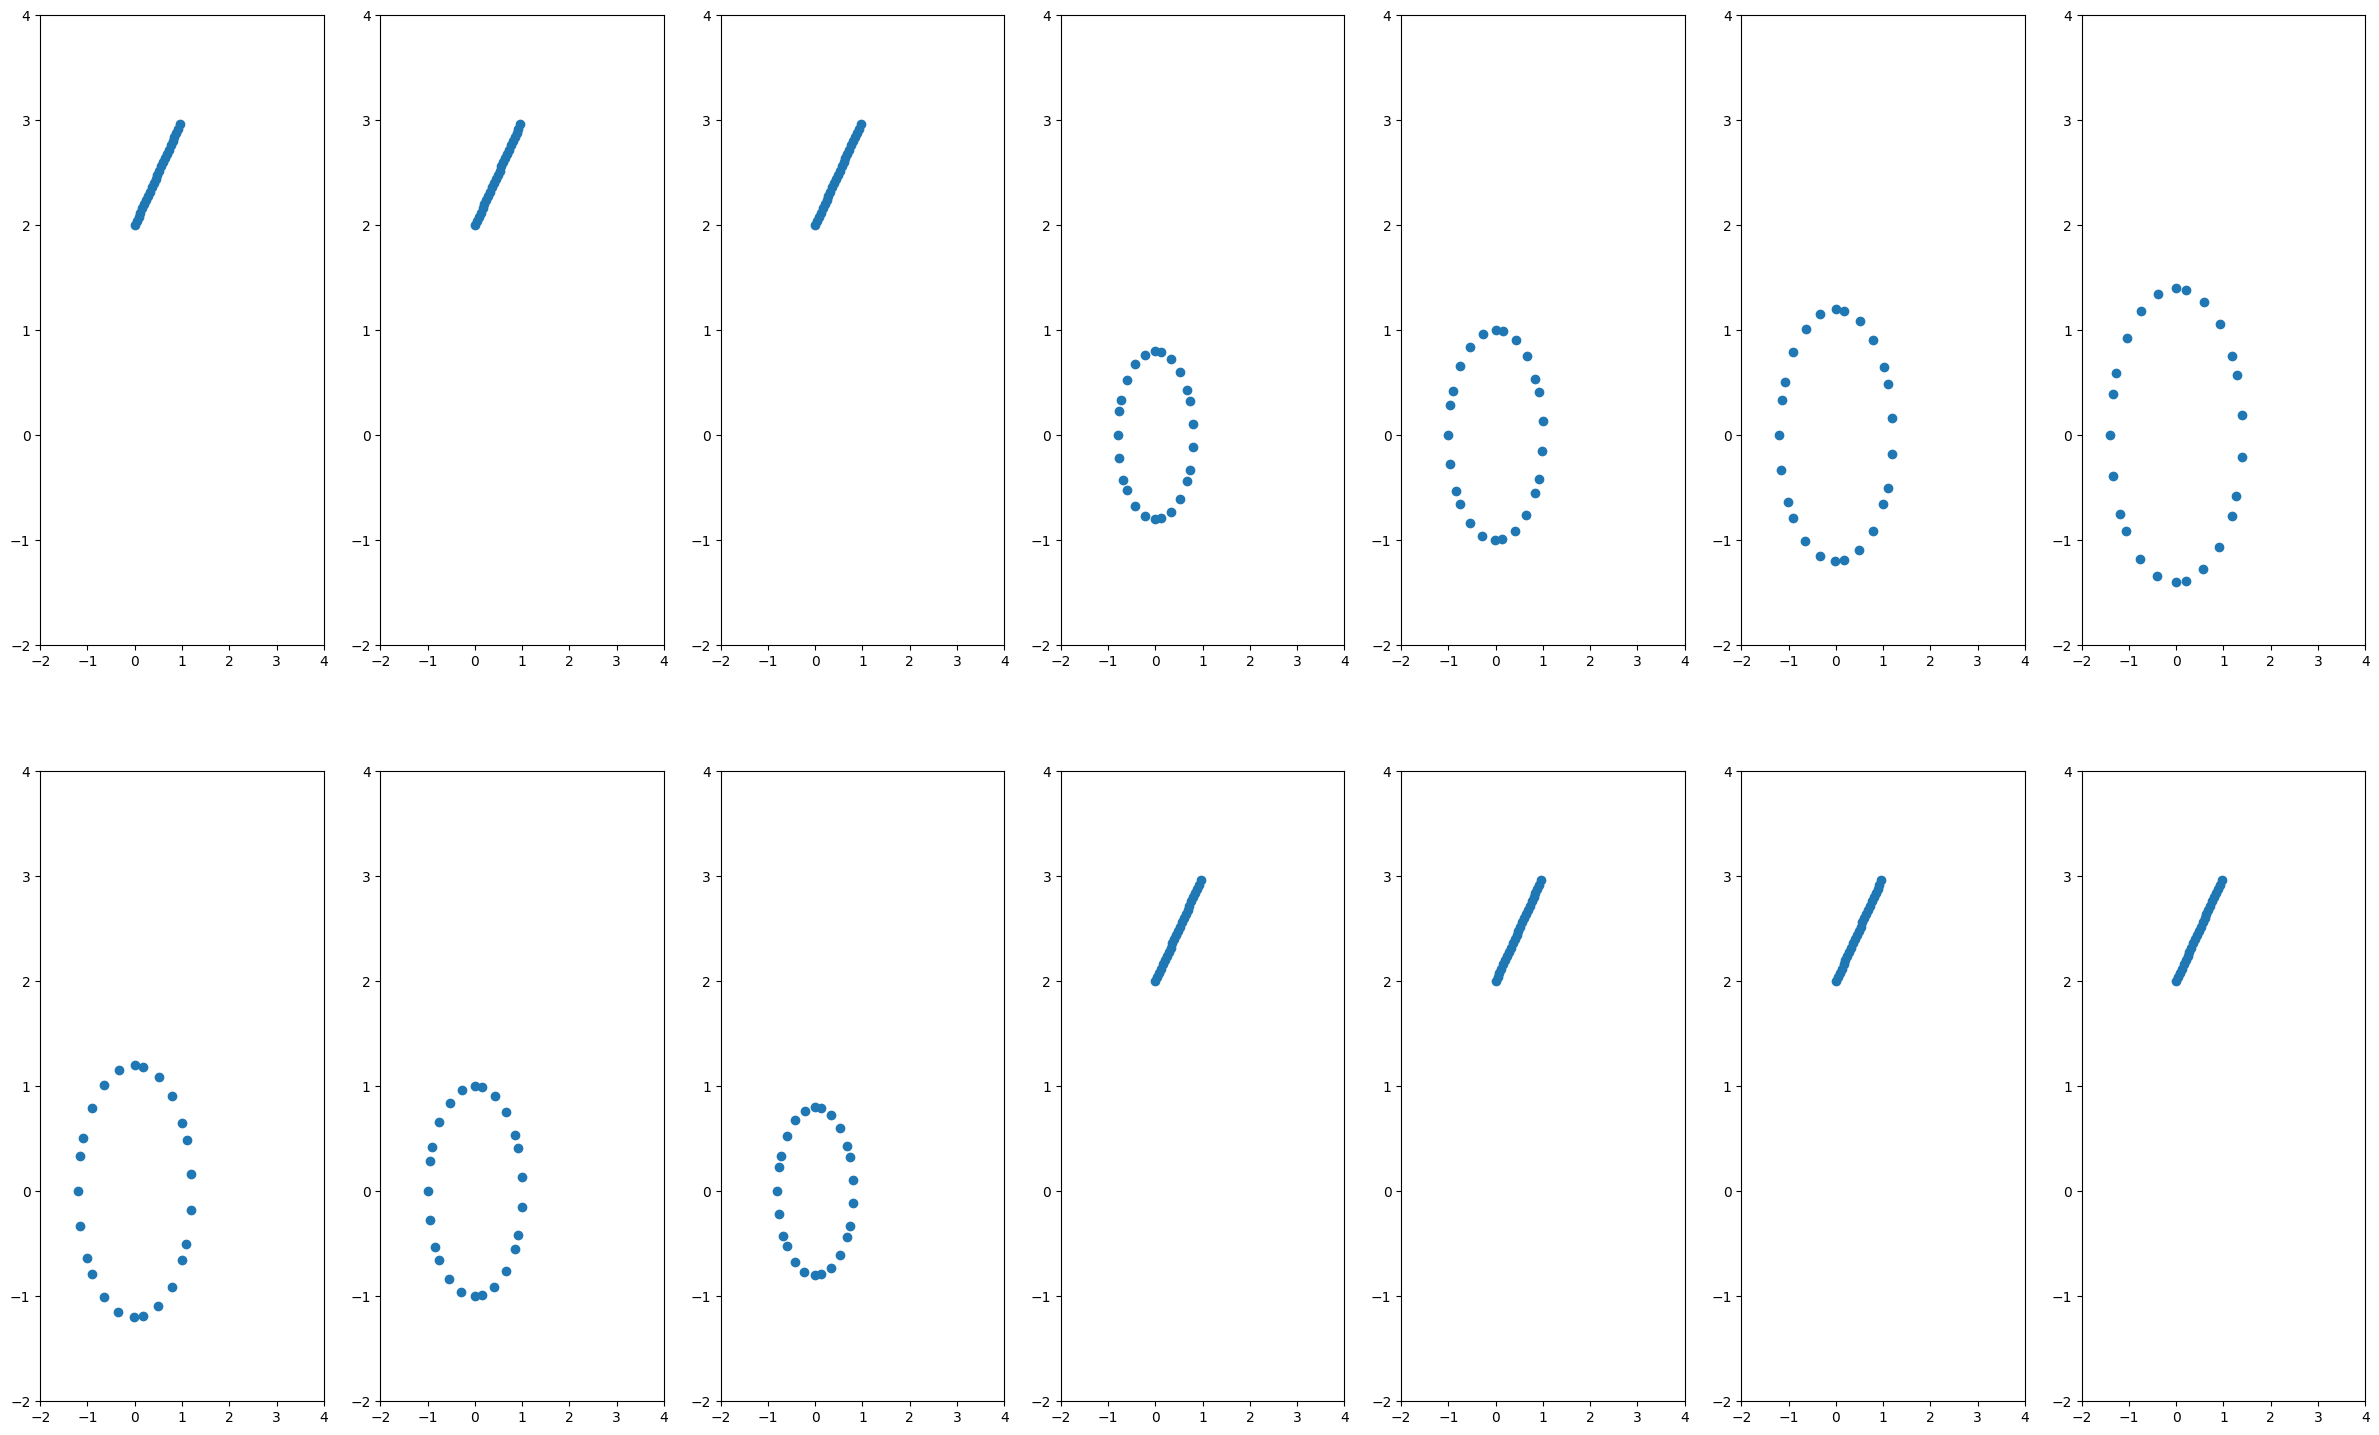

In [13]:
nrow = 2
ncol = 7

zigzagDataList = []
regionLengthList = []
figure, ax = plt.subplots(nrow, ncol, figsize=(30,18))
for i in range(nrow):
    for j in range(ncol):
        ax[i, j].scatter(samples[i*ncol + j][:, 0], samples[i*ncol + j][:, 1])
        ax[i, j].set_xlim([-2, 4])
        ax[i, j].set_ylim([-2, 4])
        zigzagDataList.append(samples[i*ncol + j])
        regionLengthList.append(len(samples[i*ncol + j]))
plt.show()


In [14]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

tempPtCldLengthList = []
for i in zigzagDataList:
    tempPtCldLengthList.append(len(i))
ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
ptCldLengthList.insert(0, 0)
ptCldLengthList = np.array(ptCldLengthList)

def setup_Zigzag_fixed(lst, r, verbose=False):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 2, r)
    # rips = getAlphaShapeComplex(lst[0], regionLengthList[0])
    for s in rips:
        s.data = 0.0
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):
        print ('Working on number {}'.format(i))
        # Calculate rips of X_{i-1} \cup X_i

        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r)
        rips = shift_filtration(rips, ptCldLengthList[i-1])
        for s in rips:
            s.data = 0.0

        # Set of vertices in R(X_i)
        # B = getAlphaShapeComplex(lst[i], regionLengthList[i])
        B = d.fill_rips(lst[i].astype(np.float32), 2, r)
        B = shift_filtration(B, ptCldLengthList[i])
        for s in B:
            s.data = 0.0

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:

            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('simp: {}'.format(simp))
            #print ('body:{}'.format(bdy))
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if simp in A:
                continue

            elif simp in B:
                continue

            else:
                #if simp not in simps_list:
                M.add(simp)

        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    print ('length of time list: {}'.format(len(times_list)))
    print ('length of simp list: {}'.format(len(simps_list)))
    print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [15]:
filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 0.5)
#zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)

Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
Working on number 8
Working on number 9
Working on number 10
Working on number 11
Working on number 12
Working on number 13
length of time list: 27938
length of simp list: 27938
length of filtration: 27938


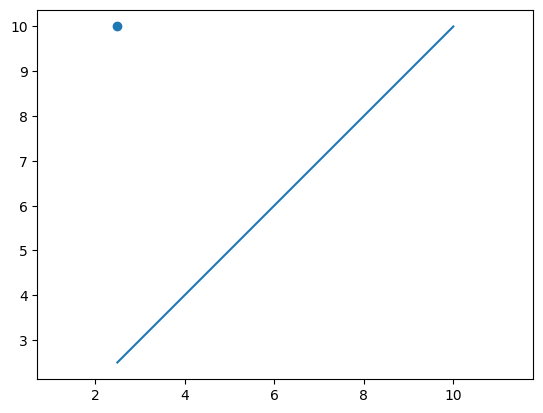

In [16]:
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)
d.plot.plot_diagram(dgms[1], show = True)

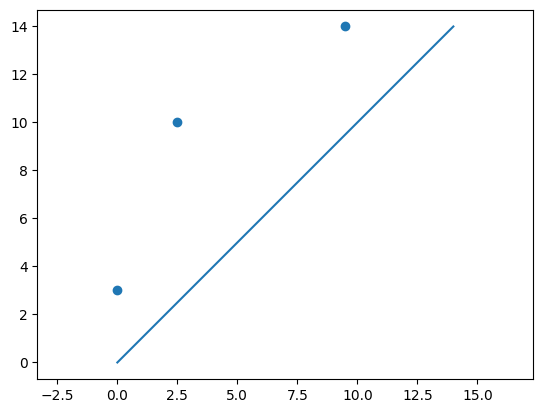

In [17]:
d.plot.plot_diagram(dgms[0], show = True)

In [19]:
birth0 = [dgm.birth for dgm in dgms[0]]
death0 = [dgm.death for dgm in dgms[0]]
birth1 = [dgm.birth for dgm in dgms[1]]
death1 = [dgm.death for dgm in dgms[1]]

p0, p1 = [[birth0,death0],[birth1,death1]]

print (p0)
print (p1)


[[0.0, 2.5, 9.5], [3.0, 10.0, 14.0]]
[[2.5], [10.0]]
